# Pan Card Tampering Detection


- The project here allows different organizations to detect whether there is any tampering or whether the given id is original or not.

- This uses Computer Vision

- We will use structural similarity of the pan card to predict whether there is any tampering or not

# Things to learn before doing this project

### Structural Similarity Index

- Image quality metric
- SSIM is used as a metric to measure the similarity between two given images.
- Reference image should be of perfect quality
- SSIM is often used as a loss function
- Value between -1 and +1.
- A value of +1 indicates that the 2 given images are very similar or the same while a value of -1 indicates the 2 given images are very different.


### Stream = True

- Setting stream=True means that requests will not download the whole response immediately. Instead, it will provide a Response object and you can iterate over the response data in chunks as needed.

### .raw in requests.get

- Without .raw we will get just the response status. But with the use .raw we will be getting httpresponse which can be used with Image.open to retrieve the image that we want from the url.

# Loading libraries

In [91]:
from skimage.metrics import structural_similarity
import imutils
import cv2
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!mkdir pan_card_tampering
!mkdir pan_card_tampering/image

In [12]:
req_original = requests.get("https://www.thestatesman.com/wp-content/uploads/2019/07/pan-card.jpg", stream=True).raw
req_original

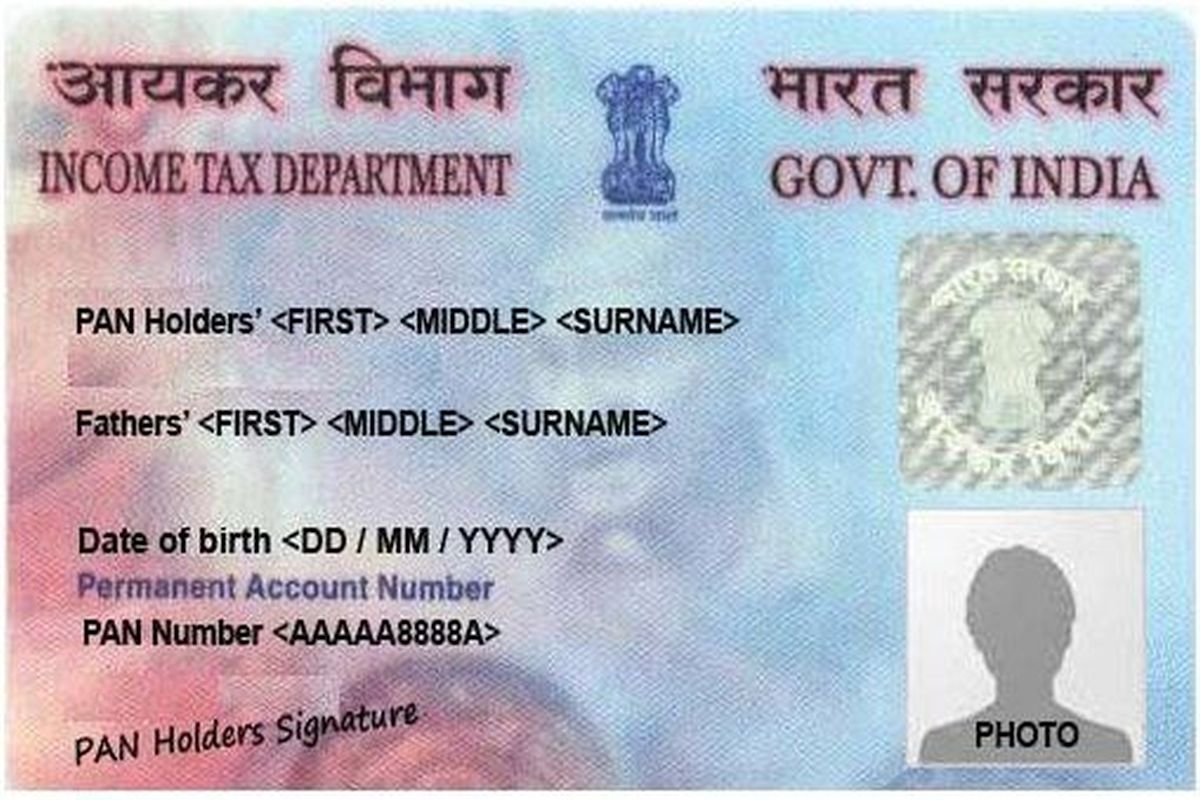

In [13]:
original = Image.open(req_original)
original

In [14]:
req_tampered = requests.get("https://assets1.cleartax-cdn.com/s/img/20170526124335/Pan4.png", stream=True).raw
req_tampered

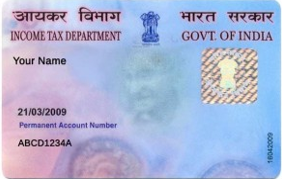

In [15]:
tampered = Image.open(req_tampered)
tampered

In [17]:
print("Original format: ", original.format)
print("Tampered format: ", tampered.format)


Original format:  JPEG
Tampered format:  PNG


In [18]:
print("Original size: ", original.size)
print("Tampered size: ", tampered.size)

Original size:  (1200, 800)
Tampered size:  (282, 179)


In [19]:
original = original.resize((250,160))
tampered = tampered.resize((250,160))

In [20]:
original.save("pan_card_tampering/image/original.png")
tampered.save("pan_card_tampering/image/tampered.png")

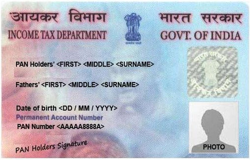

In [21]:
original

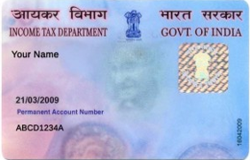

In [22]:
tampered

In [23]:
original = cv2.imread("pan_card_tampering/image/original.png")
tampered = cv2.imread("pan_card_tampering/image/tampered.png")

In [25]:
original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
tampered_gray = cv2.cvtColor(tampered, cv2.COLOR_BGR2GRAY)

array([[254, 254, 253, ..., 253, 253, 254],
       [254, 251, 249, ..., 248, 249, 252],
       [253, 249, 252, ..., 249, 247, 251],
       ...,
       [249, 229, 217, ..., 190, 200, 238],
       [251, 248, 246, ..., 238, 241, 247],
       [253, 254, 253, ..., 255, 254, 253]], dtype=uint8)
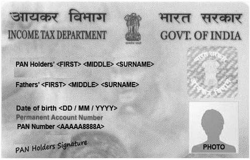

In [26]:
original_gray

array([[254, 254, 254, ..., 252, 252, 254],
       [254, 254, 254, ..., 251, 251, 253],
       [254, 254, 250, ..., 238, 252, 252],
       ...,
       [253, 255, 250, ..., 236, 251, 252],
       [254, 253, 253, ..., 248, 253, 253],
       [255, 254, 254, ..., 253, 253, 250]], dtype=uint8)
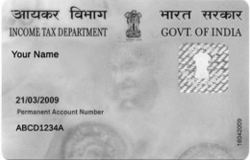

In [27]:
tampered_gray

In [45]:
max_diff = structural_similarity(original_gray, tampered_gray, full = True)[1].flatten().max()
min_diff = structural_similarity(original_gray, tampered_gray, full = True)[1].flatten().min()

In [42]:
score, diff = structural_similarity(original_gray, tampered_gray, full = True)

diff = (diff * 255).astype('uint8')

In [46]:
print("SSIM Score : ", score)
print("diff array : ", diff)
print("Max diff array: ", max_diff * 255)
print("Min diff array: ", min_diff * 255)

SSIM Score :  0.31686135690489126
diff array :  [[215 208 191 ...  91  87  91]
 [214 215 204 ... 121 119 111]
 [218 221 218 ... 150 148 140]
 ...
 [183 199 198 ... 179 183 193]
 [174 190 178 ... 156 167 183]
 [149 179 171 ... 141 149 156]]
Max diff array:  248.4136546993851
Min diff array:  -185.33881598245975


In [63]:
thresh_max = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV)[1].flatten().max()
thresh_min = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV)[1].flatten().min()
print("Unique values: ", np.unique(cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV)[1].flatten()))
print("Threshold max : ", thresh_max)
print("Threshold min : ", thresh_min)


Unique values:  [  0 255]
Threshold max :  255
Threshold min :  0


array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
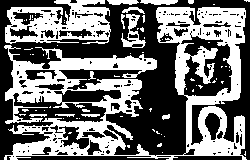

In [74]:
thresh = cv2.threshold(diff, 0 , 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
thresh

In [81]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

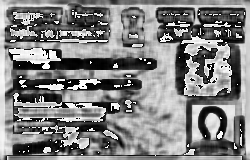

In [84]:
Image.fromarray(diff)

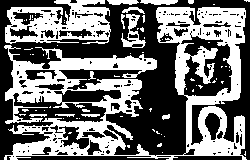

In [85]:
Image.fromarray(thresh)

In [103]:
def similar_or_not(original, tampered):
  score, diff = structural_similarity(original, tampered, full=True)
  print("SSIM Score : ", score)
  if (score > 0.75 and score <= 1.0):
    print("SSIM Score suggests that the given id's are similar and not Tampered. ")
  else:
    print("SSIM Score suggests that the given id is tampered or is not original.")
  diff = (diff * 255).astype("uint8")
  thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  plt.subplot(1,2,1)
  plt.imshow(Image.fromarray(diff))
  plt.subplot(1,2,2)
  plt.imshow(Image.fromarray(thresh))

SSIM Score :  0.31686135690489126
SSIM Score suggests that the given id is tampered or is not original.


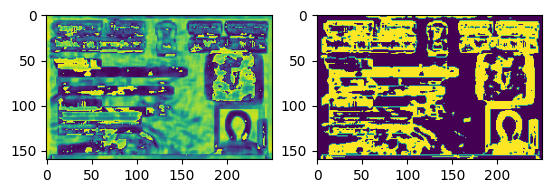

In [104]:
similar_or_not(original_gray, tampered_gray)

SSIM Score :  1.0
SSIM Score suggests that the given id's are similar and not Tampered. 


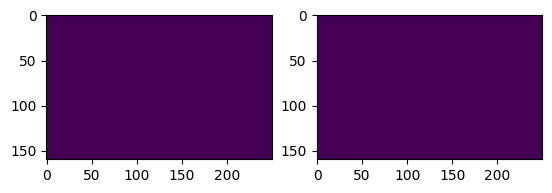

In [105]:
similar_or_not(tampered_gray, tampered_gray)

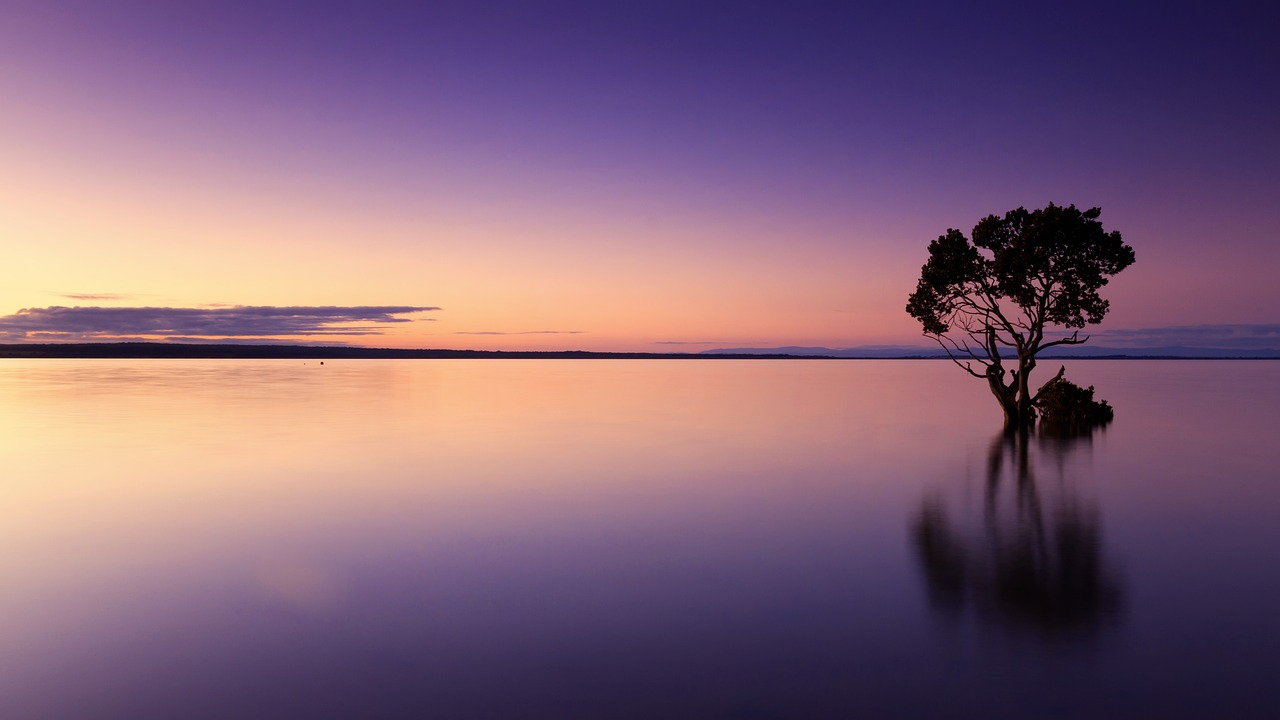

In [115]:
Image.open(requests.get("https://cdn.pixabay.com/photo/2016/05/05/02/37/sunset-1373171_1280.jpg", stream=True).raw)